# Analyze accounts

In this step we search for insights about the accounts.

In [1]:
import collections
import json
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()

%matplotlib inline

plt.style.use("seaborn")

## Load the data

In [2]:
data_directory = os.path.join("..", "..", "..", "data")

In [3]:
results_file_path = os.path.join(data_directory, "insertion_results.json")
if not os.path.exists(results_file_path):
    with tarfile.open(os.path.join(data_directory, "insertion_results.tar.xz"), "r", encoding="utf-8") as compressed_file:
        compressed_file.extract("insertion_results.json", data_directory)

In [4]:
with open(results_file_path, "r", encoding="utf-8") as results_file:
    results = []
    line = results_file.readline().strip()
    while line != "":
        results.append(json.loads(line))
        line = results_file.readline().strip()

In [5]:
with open(os.path.join(data_directory, "insertion_bot_hash_to_cluster_id.json"), "r") as json_file:
    bot_hash_to_cluster_id = json.load(json_file)

In [6]:
with open(os.path.join(data_directory, "insertion_attacker_hash_to_cluster_id.json"), "r") as json_file:
    attacker_hash_to_cluster_id = json.load(json_file)

## Collect into data frames

In [7]:
Wei_to_KWei = 1e3
Wei_to_MWei = 1e6
Wei_to_GWei = 1e9
Wei_to_Ether = 1e18

In [8]:
attacker_graph = nx.Graph()

token_attack_count = collections.Counter()
whale_attack_count = collections.Counter()
bot_attack_count = collections.Counter()
interface_attack_count = collections.Counter()

bot_attackers = collections.defaultdict(lambda: set())
bot_exchanges = collections.defaultdict(lambda: set())
bot_profits = collections.defaultdict(lambda: 0.0)

bot_first_blocks = dict()

accounts = set()

block_numbers = []
first_attackers = []
whales = []
second_attackers = []
first_gas_price_deltas = []
second_gas_price_deltas = []
profits = []
costs = []
interfaces = []
exchanges = []
tokens = []
bots = []

for result in results:
    # define some shortcut variables to make code more readable
    first_transaction = result["first_transaction"]
    whale_transaction = result["whale_transaction"]
    second_transaction = result["second_transaction"]
    
    first_attacker = first_transaction["from"]
    whale = whale_transaction["from"]
    second_ataccker = second_transaction["from"]
    bot = result["bot_address"]
    
    profit = result["profit_usd"]
    cost = result["cost_usd"]
    exchange = result["exchange_name"]
    token = result["token_name"]
    block_number = result["block_number"]
    interface = result["interface"]
    
    # initialize first attacker node if needed
    if not attacker_graph.has_node(first_attacker):
        attacker_graph.add_node(first_attacker,
                                first_attacks=0,
                                second_attacks=0,
                                both_attacks=0,
                                exchange_attacks=0,
                                bot_attacks=0,
                                total_profit_usd=0,
                                exchanges=set())
    # initialize second attacker node if needed
    if not attacker_graph.has_node(second_ataccker):
        attacker_graph.add_node(second_ataccker,
                                first_attacks=0,
                                second_attacks=0,
                                both_attacks=0,
                                exchange_attacks=0,
                                bot_attacks=0,
                                total_profit_usd=0,
                                exchanges=set())
    # initialize edge if needed
    if not attacker_graph.has_edge(first_attacker, second_ataccker):
        attacker_graph.add_edge(first_attacker, second_ataccker,
                                exchange_attacks=0,
                                bot_attacks=0,
                                total_profit_usd=0,
                                exchanges=set())
    
    # exchange interface
    if interface == "exchange":
        # assert first_transaction["to"] == whale_transaction["to"] == second_transaction["to"]
        assert bot is None
        
        attacker_graph.nodes[first_attacker]["exchange_attacks"] += 1
        if first_attacker != second_ataccker:  # different attackers
            attacker_graph.nodes[second_ataccker]["exchange_attacks"] += 1
        attacker_graph.edges[first_attacker, second_ataccker]["exchange_attacks"] += 1
    # bot interface
    elif interface == "bot":
        assert bot is not None
        
        bot_attack_count[bot] += 1
        bot_exchanges[bot].add(exchange)
        bot_attackers[bot].add(first_attacker)
        bot_attackers[bot].add(second_ataccker)
        bot_profits[bot] += profit
        
        if bot not in bot_first_blocks:
            bot_first_blocks[bot] = block_number
            
        attacker_graph.nodes[first_attacker]["bot_attacks"] += 1
        if first_attacker != second_ataccker:  # different attackers
            attacker_graph.nodes[second_ataccker]["bot_attacks"] += 1
        attacker_graph.edges[first_attacker, second_ataccker]["bot_attacks"] += 1
    # invalid interface
    else:
        raise Exception("Invalid interface.")
        
    # update first bot node properties
    attacker_graph.nodes[first_attacker]["first_attacks"] += 1
    attacker_graph.nodes[first_attacker]["total_profit_usd"] += profit
    attacker_graph.nodes[first_attacker]["exchanges"].add(exchange)
    
    # update second bot node properties
    attacker_graph.nodes[second_ataccker]["second_attacks"] += 1
    if first_attacker == second_ataccker:  # same attackers
        attacker_graph.nodes[second_ataccker]["both_attacks"] += 1
    else:  # different attackers
        attacker_graph.nodes[second_ataccker]["total_profit_usd"] += profit
        attacker_graph.nodes[second_ataccker]["exchanges"].add(exchange)
    
    # update edge properties
    attacker_graph.edges[first_attacker, second_ataccker]["total_profit_usd"] += profit
    attacker_graph.edges[first_attacker, second_ataccker]["exchanges"].add(exchange)
    
    # update counters outside the graph
    token_attack_count[token] += 1
    whale_attack_count[whale] += 1
    interface_attack_count[interface] += 1
    
    # update lists outside the graph
    block_numbers.append(block_number)
    first_attackers.append(first_attacker)
    whales.append(whale)
    second_attackers.append(second_ataccker)
    first_gas_price_deltas.append((first_transaction["gasPrice"] - whale_transaction["gasPrice"]) / Wei_to_GWei)
    second_gas_price_deltas.append((whale_transaction["gasPrice"] - second_transaction["gasPrice"]) / Wei_to_GWei)
    profits.append(profit)
    costs.append(cost)
    exchanges.append(exchange)
    interfaces.append(interface)
    tokens.append(token)
    bots.append(bot)
    
    accounts.add(first_attacker)
    accounts.add(whale)
    accounts.add(second_ataccker)
    
# some numbers
print("number of exchange attacks", interface_attack_count["exchange"])
print("number of bot attacks", interface_attack_count["bot"])
print("number of attacks", len(results))
print("number of different tokens involved", len(token_attack_count))
print("number of unique attackers involved", len(attacker_graph.nodes))
print("number of unique whale accounts involved", len(whale_attack_count))
print("number of unique accounts involved", len(accounts))

number of exchange attacks 2673
number of bot attacks 194018
number of attacks 196691
number of different tokens involved 3200
number of unique attackers involved 1504
number of unique whale accounts involved 40085
number of unique accounts involved 41350


## Collect data in data frames

In [9]:
df_attackers = pd.DataFrame({
    "Attacker Hash": pd.Series([], dtype="object"),
    "First Attacks": pd.Series([], dtype="int"),
    "Second Attacks": pd.Series([], dtype="int"),
    "Both Attacks": pd.Series([], dtype="int"),
    "Attacks": pd.Series([], dtype="int"),
    "Exchange Attacks": pd.Series([], dtype="int"),
    "Bot Attacks": pd.Series([], dtype="int"),
    "Profit": pd.Series([], dtype="float"),
    "Exchange Count": pd.Series([], dtype="int"),
    "Neighbors": pd.Series([], dtype="int"),
    "Bot Cluster ID": pd.Series([], dtype="int"),
})

for attacker in attacker_graph.nodes:
    node = attacker_graph.nodes[attacker]
    df_attackers = df_attackers.append({
        "Attacker Hash": attacker,
        "First Attacks": node["first_attacks"],
        "Second Attacks": node["second_attacks"],
        "Both Attacks": node["both_attacks"],
        "Attacks": node["first_attacks"] + node["second_attacks"] - node["both_attacks"],
        "Exchange Attacks": node["exchange_attacks"],
        "Bot Attacks": node["bot_attacks"],
        "Profit": node["total_profit_usd"],
        "Exchange Count": len(node["exchanges"]),
        "Neighbors": len(list(attacker_graph.neighbors(attacker))),
        "Bot Cluster ID": attacker_hash_to_cluster_id.get(attacker),  # will give None if bot clusters are not updated
    }, ignore_index=True)
    
df_attackers.sample(n=5)

,Attacker Hash,First Attacks,Second Attacks,Both Attacks,Attacks,Exchange Attacks,Bot Attacks,Profit,Exchange Count,Neighbors,Bot Cluster ID
1386,0x28fBdD0F0B12eC38D4aD2A21f3b8F4Cda99A313E,2,2,2,2,0,2,59.890994,1,1,24
1491,0xB28Aa6f5B5AD35c5C9d820A66e460E5b63A5EE71,2,2,2,2,0,2,-7.066279,1,1,92
1337,0xFb42A840dd3f608C7fCeB2A88e004B5eDDd71526,3,3,3,3,0,3,82.502580,1,1,24
196,0xe959B6adC52b65D30AA58B50a3A2d7924658dD3D,6,6,6,6,0,6,28.146412,1,1,9
1462,0xfb330143938677dc6d4046E2bFCe493F3005B8f0,3,3,3,3,0,3,89.768748,1,1,24


In [10]:
df_attackers.to_csv(os.path.join(data_directory, "insertion_attackers.csv"), index=False)

In [11]:
df_bots = pd.DataFrame({
    "Bot Hash": bot_profits.keys(),
    "Profit": [bot_profits[bot] for bot in bot_profits.keys()],
    "Attacks": [bot_attack_count[bot] for bot in bot_profits.keys()],
    "Attackers": [len(bot_attackers[bot]) for bot in bot_profits.keys()],
    "Exchange Count": [len(bot_exchanges[bot]) for bot in bot_profits.keys()],
    "First Block": [bot_first_blocks[bot] for bot in bot_profits.keys()],
    "Cluster ID": [bot_hash_to_cluster_id[bot] for bot in bot_profits.keys()],
})

df_bots.sample(n=5)

,Bot Hash,Profit,Attacks,Attackers,Exchange Count,First Block,Cluster ID
366,0x9980fC4754f789ffA32E5a9CF089F82741B355e2,-153.338070,18,2,1,11278207,68
55,0x0B301C47264D86629B0BEeCe3f59d5AED4DdB932,285.116475,60,1,1,9434371,5
431,0xBB1d0f7c234ce56e4FF02A968962CCe5d2a661d3,158.613259,1,2,1,10836738,32
409,0x5E14DE7d66Ab75338bDb5ba6b3E332896F3e7f80,-2.725393,1,1,1,11005134,66
32,0xcd33B0592Aff3a996614430bf6F8f5354e150F03,49.330621,15,3,1,7165204,4


In [12]:
df_bots.to_csv(os.path.join(data_directory, "insertion_bots.csv"), index=False)

In [13]:
df_whales = pd.DataFrame({
    "Whale Hash": whale_attack_count.keys(),
    "Attack Count": whale_attack_count.values()
})

df_whales.sample(n=5)

,Whale Hash,Attack Count
10406,0xb596f0aF08a0b066B2C305DA542C97312DbddcCf,2
35078,0xB86C4F832DD86b99b1f530Bc182F6358721F1a9f,2
4557,0xB7aBdcB6A334845125d94313c7255B8984deED12,8
5633,0xfB7E8100941b19741D19258c7ed511096FF1bcD3,1
3068,0x72D2B655d74f2363c0a0F35665124F7DE26E97Fc,8


In [14]:
df_tokens = pd.DataFrame({
    "Token": token_attack_count.keys(),
    "Attack Count": token_attack_count.values()
})

df_tokens.sample(n=5)

,Token,Attack Count
2924,yCORE,8
580,Tacos,268
1785,AlisToken,2
1271,Pussy Cat Core,32
52,Invacio Coin,77


In [15]:
df_attacks = pd.DataFrame({
    "Block Number": block_numbers,
    "First Attacker": first_attackers,
    "Whale": whales,
    "Second Attacker": second_attackers,
    "First-Whale Gas Price Delta": first_gas_price_deltas,
    "Whale-Second Gas Price Delta": second_gas_price_deltas,
    "Profit": profits,
    "Cost": costs,
    "Interface": interfaces,
    "Exchange": exchanges,
    "Token": tokens,
    "Bot": bots,
    "Bot Cluster ID": [bot_hash_to_cluster_id.get(bot) for bot in bots],  # will give None if bot clusters are not updated
})

df_attacks.sample(n=5)

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
162843,10719882,0x3d91b98197a5CBC69d21Fb904FEfe149Ff807599,0x7B7985dc176Cc85D70356F3720AADd2636626C12,0x3d91b98197a5CBC69d21Fb904FEfe149Ff807599,1.576000e+03,1.000000e-09,-5.456229,81.605298,bot,Uniswap V2,SHRIMP.FINANCE,0xec48D2C85d18992B7454474e00587765b93593eD,24.0
160639,11166064,0xB06c901509ee27937572382463A3Ed59efCfF595,0x7101A39C053954e3E7fD010fDF3F6Ef6bDBCBde0,0xB06c901509ee27937572382463A3Ed59efCfF595,1.000000e-09,1.000000e-09,7.457060,4.433683,bot,Uniswap V2,DUFF BEER TOKEN,0xf27B6320E9Fa107c9AE72f1C82fa57000FbC0792,37.0
70871,10059925,0xdD7B4EB004C74A43B7fbC65610a83fC074667Ce4,0xaA6B5fCb8bc2C3d6C4b56735fFcC44390820ed2C,0x1cF7BD45300699f506deC8A92ED0A13A6877F750,2.500000e+00,0.000000e+00,7.139956,0.936228,bot,Uniswap V1,FOAM Token,0x964D388BFc2CCEf359b33F6dE5D599fCE8cbd064,16.0
31212,10598947,0xdEAd27218F7243f71Bd4B7bd39c314D5cc66840e,0x31904A7c032E7Eb11F7E8447a6aa7311067C8273,0xdEAd27218F7243f71Bd4B7bd39c314D5cc66840e,1.000000e-09,1.000000e-09,9.388322,3.364331,exchange,Uniswap V2,RMPL,None,NaN
50627,10901772,0x17ab75b3BD6B9872Fe8d021d6d72bab32f91aAEf,0x136021d786490B0E3178ED863fF569C6D0Daa4aF,0x58275e42f0DDB2Ea342a1C57f4966928A66a4289,1.000000e+00,0.000000e+00,24.200864,7.704090,bot,Uniswap V2,yTSLA Finance,0xEE29fa63e27A392f454accD489233f4483174025,20.0


In [16]:
df_attacks.to_csv(os.path.join(data_directory, "insertion_attacks.csv"), index=False)

In [17]:
event_account_hash = []
event_account_role = []
event_interface = []
event_block_number = []
event_exchange = []

bot_event_account_hash = []
bot_event_block_number = []
bot_event_exchange = []

for _, row in df_attacks.iterrows():
    if row["First Attacker"] == row["Second Attacker"]:
        event_account_hash.append(row["First Attacker"])
        event_account_role.append("Both Attackers")
        event_interface.append(row["Interface"])
        event_block_number.append(row["Block Number"])
        event_exchange.append(row["Exchange"])
    else:
        event_account_hash.append(row["First Attacker"])
        event_account_role.append("First Attacker")
        event_interface.append(row["Interface"])
        event_block_number.append(row["Block Number"])
        event_exchange.append(row["Exchange"])

        event_account_hash.append(row["Second Attacker"])
        event_account_role.append("Second Attacker")
        event_interface.append(row["Interface"])
        event_block_number.append(row["Block Number"])
        event_exchange.append(row["Exchange"])
        
    event_account_hash.append(row["Whale"])
    event_account_role.append("Whale")
    event_interface.append(row["Interface"])
    event_block_number.append(row["Block Number"])
    event_exchange.append(row["Exchange"])
    
    if row["Interface"] == "bot":
        assert row["Bot"] is not None
        bot_event_account_hash.append(row["Bot"])
        bot_event_block_number.append(row["Block Number"])
        bot_event_exchange.append(row["Exchange"])
    
df_events = pd.DataFrame({
    "Account Hash": event_account_hash,
    "Account Role": event_account_role,
    "Interface": event_interface,
    "Block Number": event_block_number,
    "Exchange": event_exchange,
})

df_attacker_events = df_events[df_events["Account Role"] != "Whale"]

df_bot_events = pd.DataFrame({
    "Bot Hash": bot_event_account_hash,
    "Block Number": bot_event_block_number,
    "Exchange": bot_event_exchange,
})

del event_account_hash
del event_account_role
del event_interface
del event_block_number
del event_exchange
del bot_event_account_hash
del bot_event_block_number
del bot_event_exchange

In [18]:
df_events.sample(n=5)

,Account Hash,Account Role,Interface,Block Number,Exchange
319649,0xdC18AC54733697E00744E9980708A87783B4399F,Both Attackers,bot,10788015,Uniswap V2
281139,0x25b2A252C07A1e930a0bc87Cf250ca6DF007eA84,Both Attackers,bot,10985167,Uniswap V2
144393,0xD11B92824332F966FD7cE0ED79Cb70136C5858F7,Second Attacker,bot,10778000,Uniswap V2
225054,0x3aEC0d815D4D05b81ABA2dDdf9B38ff468F117AA,Whale,bot,11232591,Uniswap V2
152160,0xE2C9D57B79a2CA452398ab5C4589135C348D92E9,Second Attacker,bot,10804001,Uniswap V2


In [19]:
df_attacker_events.sample(n=5)

,Account Hash,Account Role,Interface,Block Number,Exchange
268407,0x51db325B736aABEE2B614957AB93b9BB5261F954,First Attacker,bot,10785057,Uniswap V2
47434,0x0Ea09d7d36d781E2A280a50d50A67A4D5e67c6C1,Second Attacker,bot,10373537,Uniswap V2
255295,0xB63C4E229da46a54b053dA51a9f8046b4f212DA0,Both Attackers,bot,11210296,Uniswap V2
146866,0x464587Ee0CC5185686b29Af7856b1D13647E93bE,Second Attacker,bot,11027945,Uniswap V2
253778,0x58275e42f0DDB2Ea342a1C57f4966928A66a4289,Second Attacker,bot,11084015,Uniswap V2


In [20]:
df_bot_events.sample(n=5)

,Bot Hash,Block Number,Exchange
4458,0x4eE51d6484B1789Ba6e6Ae766e93263F713bCB4D,7110296,Bancor
24379,0xEB46faa47A6A52519839A2e52c7b28a2Db17651e,11174545,Uniswap V2
155464,0x743DD3139C6B70f664AB4329b2CdE646f0BaC99a,10866214,Uniswap V2
6090,0xB958a8f59AC6145851729F73c7A6968311d8B633,7767101,Uniswap V1
129365,0x3F499Fe484a61Af03b01ea5C81Eab14F67C11A5A,10887805,Uniswap V2


## Free some memory now that everything is on data frames

In [21]:
del attacker_graph

del token_attack_count
del whale_attack_count
del bot_attack_count
del interface_attack_count

del bot_attackers
del bot_exchanges
del bot_profits

del bot_first_blocks

del accounts

del block_numbers
del first_attackers
del whales
del second_attackers
del first_gas_price_deltas
del second_gas_price_deltas
del profits
del interfaces
del exchanges
del tokens
del bots

## Save latex tables for the publication

In [22]:
df_attacks[[
    "Cost",
    "Profit",
    "First-Whale Gas Price Delta",
    "Whale-Second Gas Price Delta",
]].describe().style.format("{:.2f}")

,Cost,Profit,First-Whale Gas Price Delta,Whale-Second Gas Price Delta
count,196691.00,196691.00,196691.00,196691.00
mean,19.41,65.05,407.63,3.88
std,51.15,233.44,1897.47,137.12
min,0.01,-10620.61,0.00,0.00
25%,4.09,7.86,0.00,0.00
50%,7.74,24.07,5.25,0.00
75%,15.23,62.92,74.10,0.00
max,1822.22,20084.01,76236.09,27396.63


In [23]:
latex = df_attacks[[
        "Cost",
        "Profit",
        "First-Whale Gas Price Delta",
        "Whale-Second Gas Price Delta",
    ]].describe().to_latex(index=True, formatters={
        "Cost": "{:,.2f}".format,
        "Profit": "{:,.2f}".format,
        "First-Whale Gas Price Delta": "{:,.2f}".format,
        "Whale-Second Gas Price Delta": "{:,.2f}".format,
    })

with open(os.path.join(data_directory, "insertion_attack_stats.tex"), "w") as latex_file:
    latex_file.write(latex)

In [24]:
df_cluster_exchanges = df_attacks[df_attacks.Interface == "bot"][["Exchange", "Bot Cluster ID"]].groupby("Bot Cluster ID").agg({
    "Exchange": lambda values: ", ".join(sorted(set(values)))
})
df_cluster_exchanges.Exchange.value_counts()

Uniswap V2                                   72
Uniswap V1                                   16
SushiSwap, Uniswap V2                         4
Bancor                                        3
Uniswap V1, Uniswap V2                        2
Bancor, SushiSwap, Uniswap V1, Uniswap V2     1
Name: Exchange, dtype: int64

In [25]:
latex = df_cluster_exchanges.Exchange.value_counts().to_latex()

with open(os.path.join(data_directory, "insertion_exchange_combinations_by_cluster.tex"), "w") as latex_file:
    latex_file.write(latex)

## Other stats

### Common queries

In [26]:
def match_group(target, group, row, column):
    display(target[target[column] == group.reset_index().iloc[row][column]])

### Common plot definition

In [27]:
def create_palette(values):
    colors = sns.color_palette("hls", len(values))
    return {value: colors[i] for i, value in enumerate(values)}

interface_palette = create_palette(["exchange", "bot"])

exchange_combination_palette = create_palette([
    'Bancor',
    'SushiSwap',
    'Uniswap V1',
    'Uniswap V2',
    'Two Exchanges',
    'Three Exchanges',
])

In [28]:
def plot_account_field_over_time(data, field, filters={}, hue=None, palette=None):
    for filter_field, filter_value in filters.items():
        data = data[data[filter_field] == filter_value]
    
    fig, ax = plt.subplots(figsize=(10, len(data[field].unique()) + 2))
    
    sns.scatterplot(data=data,
                    x="Block Number",
                    y=field,
                    hue=hue,
                    alpha=0.75,
                    palette=palette)
    
    x_formatter = ticker.FuncFormatter(lambda value, position: "{:.2f}M".format(value / 1000000))
    ax.xaxis.set_major_formatter(x_formatter)

    plt.title(attacker)
    
    if hue is not None:
        plt.legend(loc=(0, 0.7))
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_exchange_combinations(data, group_field):
    def exchange_grouping(exchanges):
        unique_exchanges = set(exchanges)
        if len(unique_exchanges) == 1:
            return next(iter(unique_exchanges))
        elif len(unique_exchanges) == 2:
            return "Two Exchanges"
        elif len(unique_exchanges) == 3:
            return "Three Exchanges"
    
    df_exchange_combinations = pd.DataFrame({
        "Count":  data.groupby(group_field)["Exchange"].apply(exchange_grouping).value_counts()
    }).rename_axis("Exchange")

    plt.figure(figsize=(12, 6))
    
    sns.barplot(data=df_exchange_combinations,
                x=df_exchange_combinations.index,
                y="Count",
                palette=exchange_combination_palette)
    
    plt.tight_layout()
    plt.show()

In [30]:
def plot_profits_by_gas_price_delta(data, column):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_attacks, x=column, y="Profit")
    plt.xlabel("{} (GWei)".format(column))
    plt.ylabel("Profit (USD)")
    plt.tight_layout()
    plt.show()

### Distributions of attacks received per whale account

In [31]:
pd.DataFrame(df_whales["Attack Count"].describe())

,Attack Count
count,40085.000000
mean,4.906848
std,13.502791
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,658.000000


### Top 10 most attacked whale accounts

In [32]:
df_whales.sort_values(by="Attack Count", ascending=False)[:10]

,Whale Hash,Attack Count
1658,0xA694068FDfd382FA60c249e9A2B92a5548aD50EF,658
7466,0x9ee354718299915bC53B9326b9eD3E09D82B3c51,516
428,0x5aB9d116a53EF41063E3EaE26A7eBe736720E9bA,513
5353,0x6EACAC9AB65402e8d069dB326d7515a467b24CED,462
1340,0xDf8eFB8a522561EA9bD8C55874Dca4536EE5c618,425
8601,0x5c6EE738607801C34e598c1F0CA297f0b3803b11,390
1462,0x6794471ebC084A4ca462C506AfEaBb93d9657c25,384
9662,0x17bC12866439Db4bF991B4543416dD70c3AF8cD0,332
10129,0x7aBd0419cDd4983191a6d22b1A4CBF56eE06E4D7,328
1784,0x32Cd1F7BdaE90B87E9b58d25d2ef7b09f6A9B548,324


### Distributions of attacks per token involved

In [33]:
pd.DataFrame(df_tokens["Attack Count"].describe())

,Attack Count
count,3200.000000
mean,61.465938
std,170.512174
min,1.000000
25%,1.000000
50%,5.000000
75%,35.000000
max,3038.000000


### Top 10 most involved tokens

In [34]:
df_tokens.sort_values(by="Attack Count", ascending=False)[:10]

,Token,Attack Count
674,YELD,3038
249,HEX2T,1947
673,HippoFinance,1623
590,yfBETA,1513
442,YFLink,1378
559,Nyan.finance,1357
248,DMM: Governance,1357
175,Complete New Commerce Chain,1340
1031,Keep3rV1,1317
489,OM Token,1280


### Gas Price Delta

In [35]:
df_attacks[["First-Whale Gas Price Delta", "Whale-Second Gas Price Delta"]].describe().style.format("{:.2f}")

,First-Whale Gas Price Delta,Whale-Second Gas Price Delta
count,196691.00,196691.00
mean,407.63,3.88
std,1897.47,137.12
min,0.00,0.00
25%,0.00,0.00
50%,5.25,0.00
75%,74.10,0.00
max,76236.09,27396.63


Is there a correlation between the gas delta and the profit?

It does not seem so (datapoints are not placed in a diagonal).

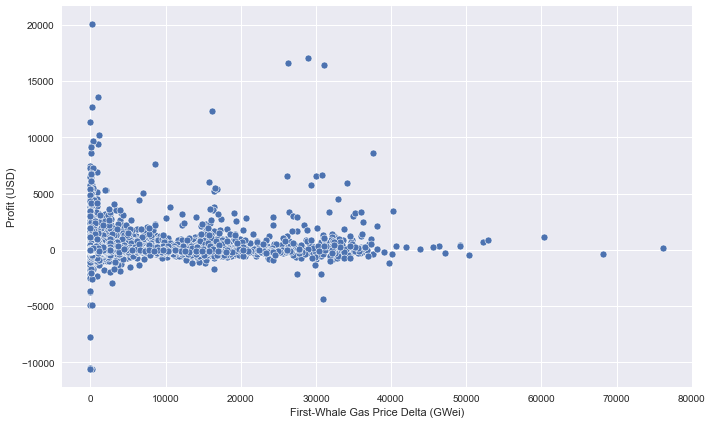

In [36]:
# try separating this by exchange -> nothing interesting happened
# can we correlate this with token popularity? -> if token popularity = # attacks then nothing interesting happens
plot_profits_by_gas_price_delta(df_attacks, "First-Whale Gas Price Delta")

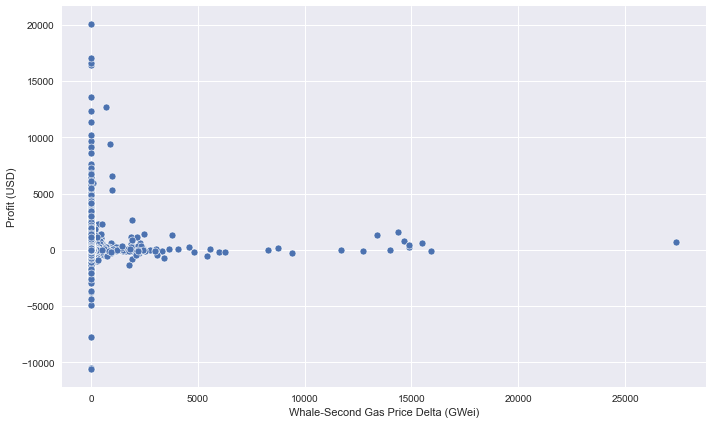

In [37]:
plot_profits_by_gas_price_delta(df_attacks, "Whale-Second Gas Price Delta")

### How many attackers are victims too?

In [38]:
attackers_that_are_victims = set(df_attackers["Attacker Hash"].unique()).intersection(df_whales["Whale Hash"].unique())
print(len(attackers_that_are_victims))

with open(os.path.join(data_directory, "insertion_attackers_that_are_victims.txt"), "w") as output_file:
    output_file.writelines("\n".join(attackers_that_are_victims))

239


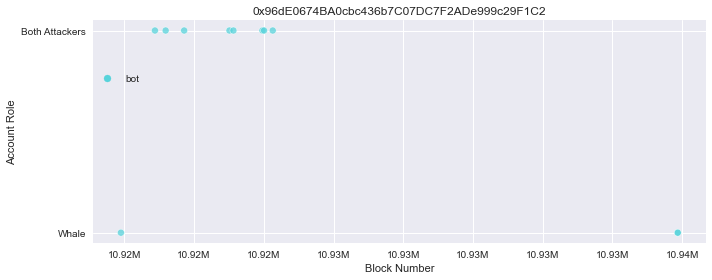

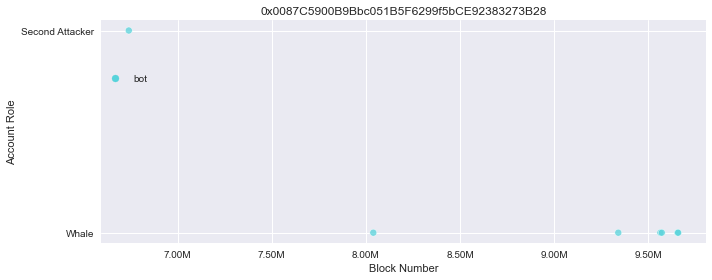

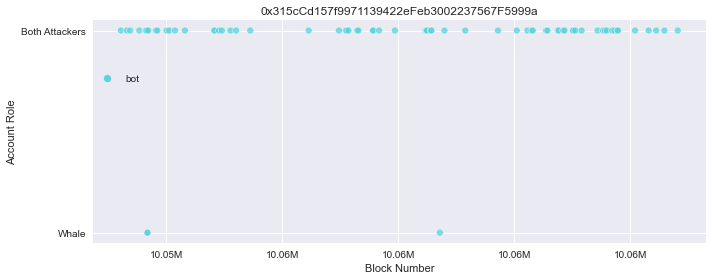

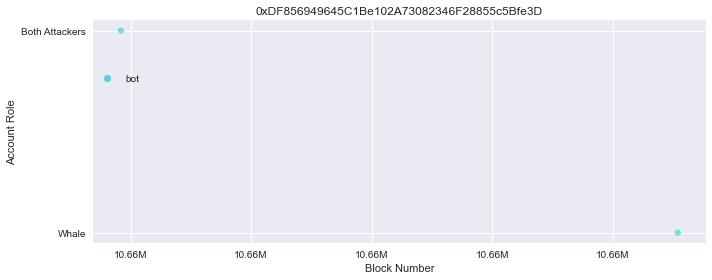

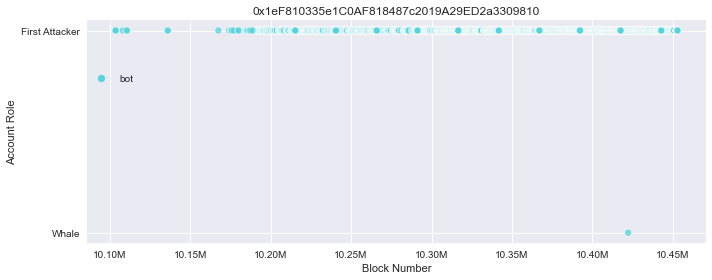

In [39]:
for attacker in list(attackers_that_are_victims)[:5]:
    plot_account_field_over_time(df_events,
                                 "Account Role",
                                 filters={"Account Hash": attacker},
                                 hue="Interface",
                                 palette=interface_palette)

### Are attackers using both interfaces at the same time?

In [40]:
only_exchange_interface = df_attackers[
    (df_attackers["Exchange Attacks"] > 0)
    & (df_attackers["Bot Attacks"] == 0)
]["Attacker Hash"].values

only_bot_interface = df_attackers[
    (df_attackers["Exchange Attacks"] == 0)
    & (df_attackers["Bot Attacks"] > 0)
]["Attacker Hash"].values

both_interfaces = df_attackers[
    (df_attackers["Exchange Attacks"] > 0)
    & (df_attackers["Bot Attacks"] > 0)
]["Attacker Hash"].values

print("only exchange interface:", len(only_exchange_interface))
print("only bot interface:", len(only_bot_interface))
print("both interfaces:", len(both_interfaces))

only exchange interface: 47
only bot interface: 1437
both interfaces: 20


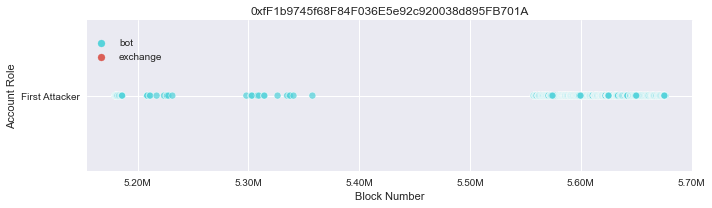

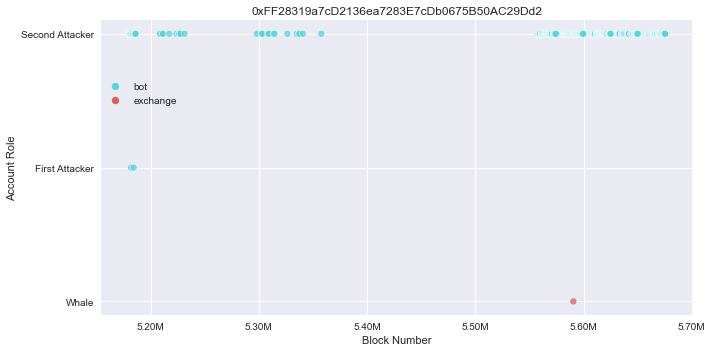

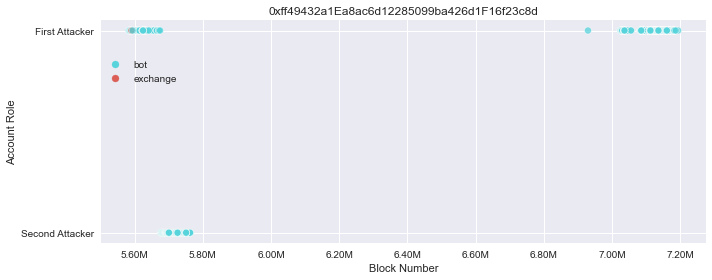

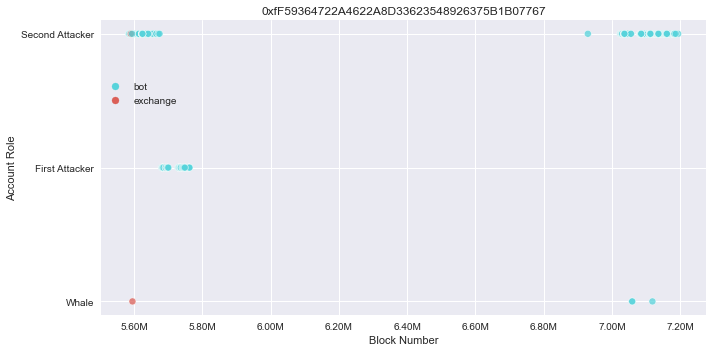

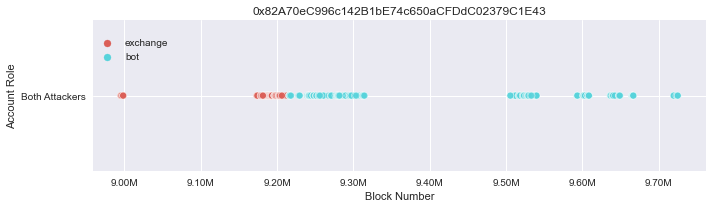

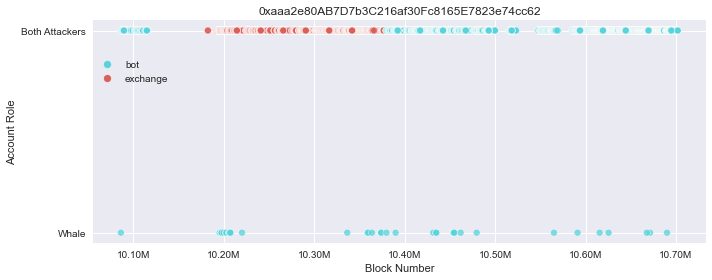

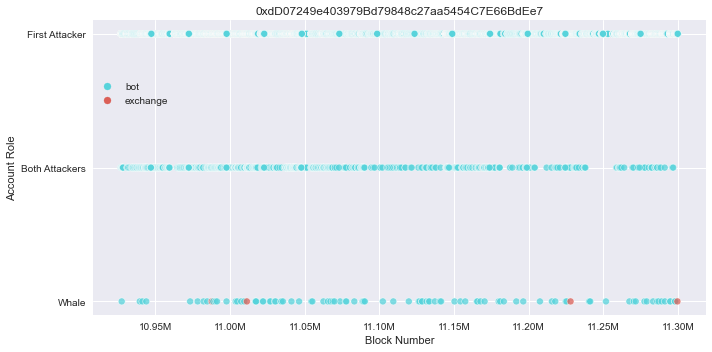

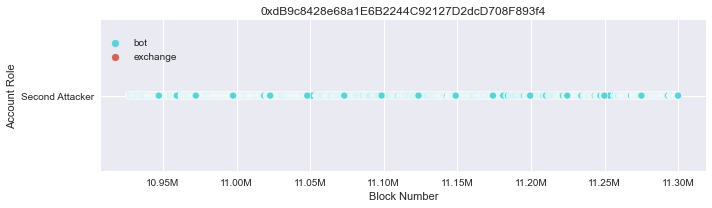

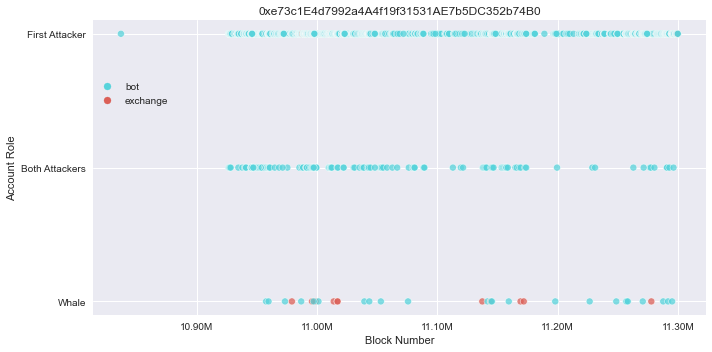

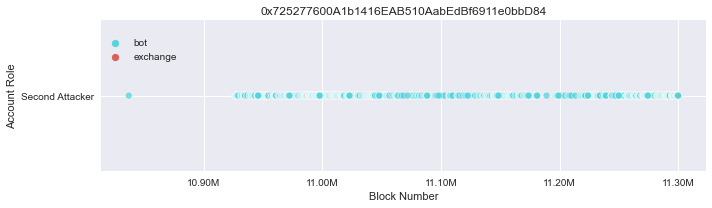

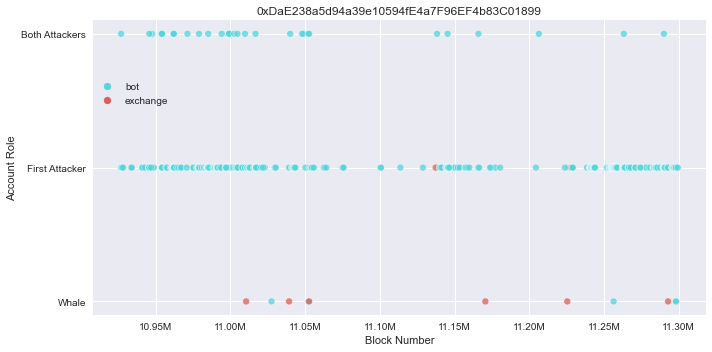

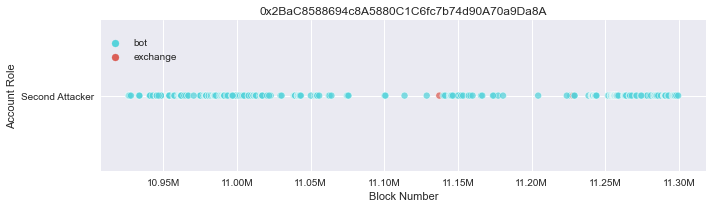

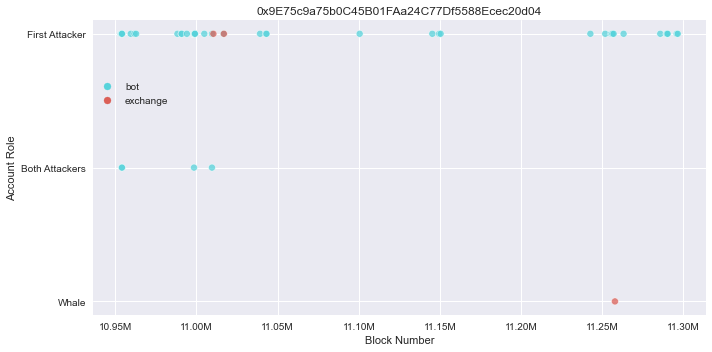

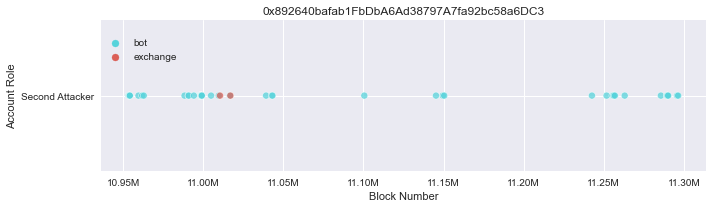

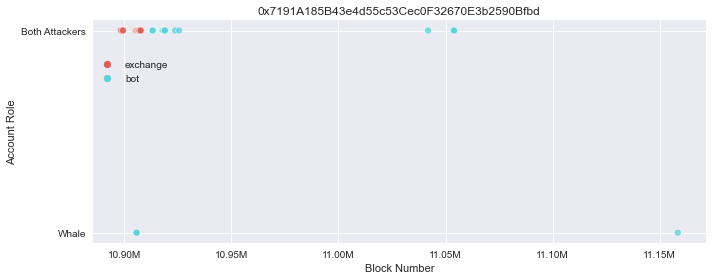

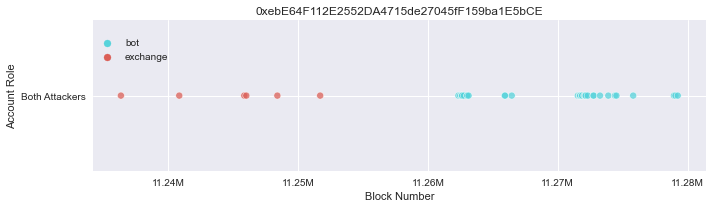

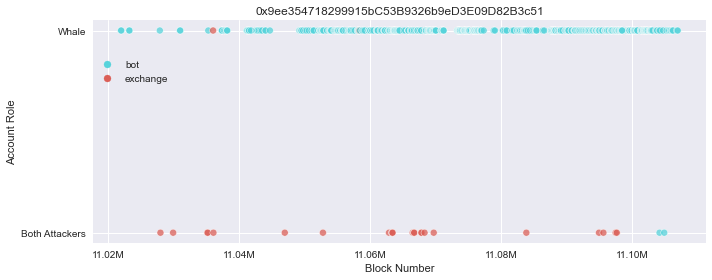

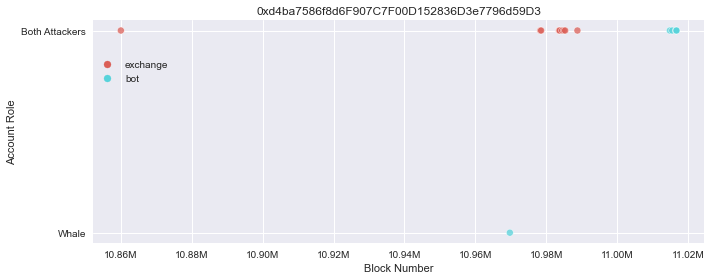

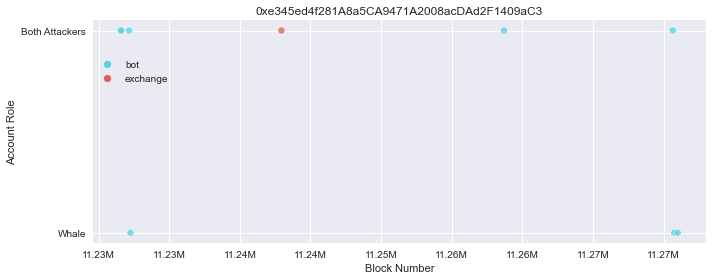

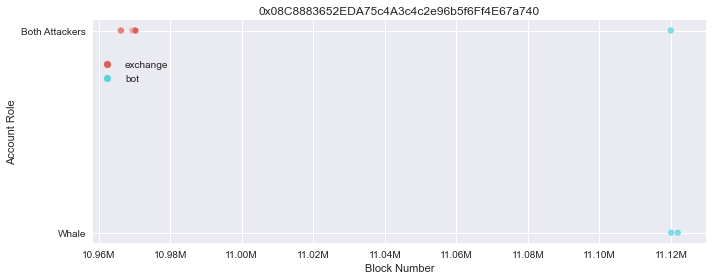

In [41]:
for attacker in both_interfaces:
    plot_account_field_over_time(df_events,
                                 "Account Role",
                                 filters={"Account Hash": attacker},
                                 hue="Interface",
                                 palette=interface_palette)

### Distribution of attacks per attacker

In [42]:
df_attackers[[
    "First Attacks",
    "Second Attacks",
    "Both Attacks",
    "Attacks",
    "Exchange Attacks",
    "Bot Attacks",
]].describe().style.format("{:.2f}")

,First Attacks,Second Attacks,Both Attacks,Attacks,Exchange Attacks,Bot Attacks
count,1504.00,1504.00,1504.00,1504.00,1504.00,1504.00
mean,130.78,130.78,73.57,187.98,1.81,186.18
std,759.31,662.20,368.55,942.37,41.58,936.96
min,0.00,0.00,0.00,1.00,0.00,0.00
25%,2.00,2.00,1.75,2.00,0.00,2.00
50%,3.00,3.00,3.00,4.00,0.00,3.00
75%,7.00,7.00,6.00,8.00,0.00,7.00
max,11898.00,10693.00,5834.00,11898.00,1560.00,11898.00


### Top 10 most active attackers

In [43]:
df_attackers.sort_values(by="Attacks", ascending=False)[:10].style.format({"Profit": "{:.2f}"})

,Attacker Hash,First Attacks,Second Attacks,Both Attacks,Attacks,Exchange Attacks,Bot Attacks,Profit,Exchange Count,Neighbors,Bot Cluster ID
273,0x86254Cb5A96C161E503d3255d67Fdddec056FEfe,11898,0,0,11898,0,11898,374738.36,1,2,20
323,0xa21caEbD27a296678176aC886735bfd18F875B8f,11621,928,928,11621,0,11621,1923285.04,2,2,30
324,0x464587Ee0CC5185686b29Af7856b1D13647E93bE,0,10693,0,10693,0,10693,1759787.59,2,1,30
300,0x17ab75b3BD6B9872Fe8d021d6d72bab32f91aAEf,10691,0,0,10691,0,10691,245437.89,1,2,20
356,0xdD07249e403979Bd79848c27aa5454C7E66BdEe7,10063,740,740,10063,8,10055,1841735.27,1,2,32
357,0xdB9c8428e68a1E6B2244C92127D2dcD708F893f4,0,9324,0,9324,7,9317,1713406.70,1,2,32
279,0xb27179Fb6d0412F0EC9873Baf26DAe3457c5494a,0,7469,0,7469,0,7469,234264.10,1,2,20
286,0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe,7175,0,0,7175,0,7175,597750.59,1,2,20
308,0x58275e42f0DDB2Ea342a1C57f4966928A66a4289,0,6900,0,6900,0,6900,152604.04,1,1,20
203,0x51db325B736aABEE2B614957AB93b9BB5261F954,6476,2018,2018,6476,0,6476,1802787.20,2,3,19


### Distribution of attacks per bot

In [44]:
pd.DataFrame(df_bots.Attacks.describe())

,Attacks
count,471.000000
mean,411.927813
std,1554.407044
min,1.000000
25%,2.500000
50%,11.000000
75%,78.500000
max,20144.000000


### Top 10 most active bots

In [45]:
df_bots.sort_values(by="Attacks", ascending=False)[:10].style.format({"Profit": "{:.2f}"})

,Bot Hash,Profit,Attacks,Attackers,Exchange Count,First Block,Cluster ID
153,0x42D0ba0223700DEa8BCA7983cc4bf0e000DEE772,1062740.28,20144,9,1,10518415,1
195,0x0000000071E801062eB0544403F66176BBA42Dc0,1923285.04,11621,2,2,10896784,30
209,0x000000000000084e91743124a982076C59f10084,1850655.33,10198,10,1,10972441,32
266,0xEB46faa47A6A52519839A2e52c7b28a2Db17651e,120090.68,8067,15,1,11174246,37
211,0x8Be4DB5926232BC5B02b841dbeDe8161924495C4,296464.62,7770,8,1,10972445,20
214,0x5f3E759d09e1059e4c46D6984f07cbB36A73bdf1,265625.62,7758,6,1,10972467,20
178,0x494Cc492c9f01699bfF1449180201dbfbD592EA5,564614.74,6857,5,1,10745425,24
144,0xdf1BAc82673D6B9A18D9C476Fd90bbECF00Fce5D,1802787.20,6476,3,2,10468148,19
205,0x00000000002bde777710C370E08Fc83D61b2B8E1,178642.43,5558,5,1,10947227,24
148,0xc3Ca90684Fd7B8C7e4BE88c329269fc32111c4bD,194083.69,5442,5,1,10443099,20


### Distribution of number of exchanges used per attacker

In [46]:
pd.DataFrame(df_attackers["Exchange Count"].describe())

,Exchange Count
count,1504.000000
mean,1.023271
std,0.163514
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


### Attackers that used the most exchanges

In [47]:
df_attackers.sort_values(by="Exchange Count", ascending=False)[:10].style.format({"Profit": "{:.2f}"})

,Attacker Hash,First Attacks,Second Attacks,Both Attacks,Attacks,Exchange Attacks,Bot Attacks,Profit,Exchange Count,Neighbors,Bot Cluster ID
2,0x4fCc2FF6c75923D33B4F5aF4C524461014B2EE1C,3570,521,521,3570,0,3570,731352.73,3,4,1
3,0x43211FfC4dB5DBD9aDB3Af3aF87B585DD0F77C8f,12,1859,12,1859,0,1859,478840.55,3,7,1
31,0xF3A3fD06A875A09d7Cd5fd18FDBE22493fC86aBD,0,1207,0,1207,0,1207,177505.19,3,2,1
55,0x76C6430BD401F0C15E073b2CD5D3b510ea720A95,2855,2855,2849,2861,0,2861,128455.89,2,5,1
324,0x464587Ee0CC5185686b29Af7856b1D13647E93bE,0,10693,0,10693,0,10693,1759787.59,2,1,30
32,0xeD7Ce3de532213314Bb07622d8Bf606a4ba03CF1,287,289,287,289,0,289,5762.96,2,3,1
175,0x5D04C4e6D9F3f369355628fc55b15B303C38Bc14,2648,2650,2648,2650,0,2650,117812.81,2,3,1
173,0x4ed50D27bae39043754AF35572958BeCe22f2C2A,242,116,116,242,0,242,4056.70,2,2,19
172,0xF45AED9CC3eb34F057736164b109cecE9215223D,0,745,0,745,0,745,18009.25,2,5,19
171,0xC3518561F4370c8b826bC6864616991b83327074,1057,504,504,1057,0,1057,17566.59,2,2,19


### Combinations of exchanges used by attackers

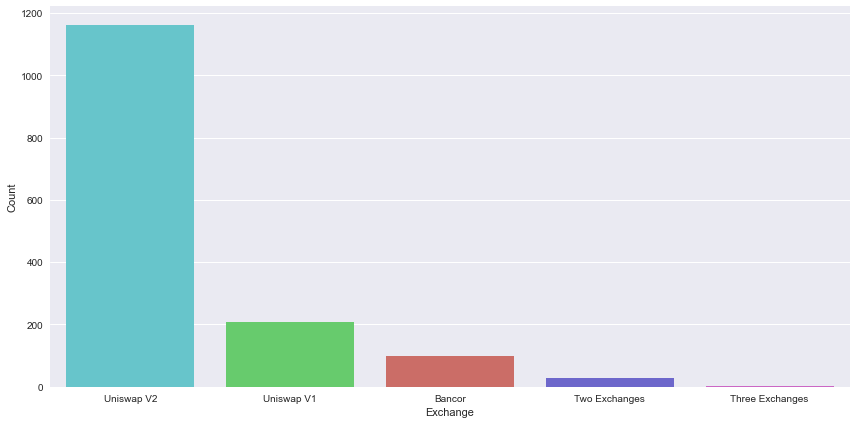

In [48]:
plot_exchange_combinations(df_attacker_events, "Account Hash")

### Exchanges used by attackers over time

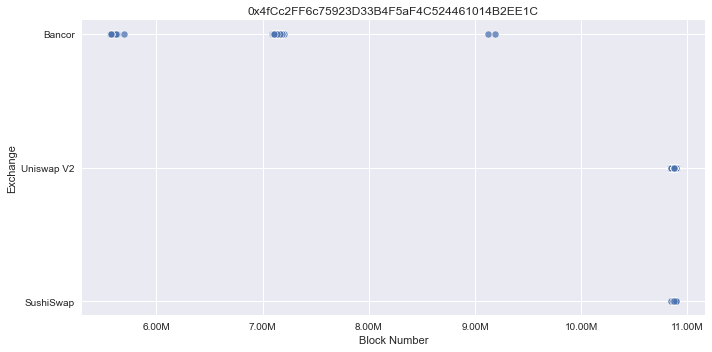

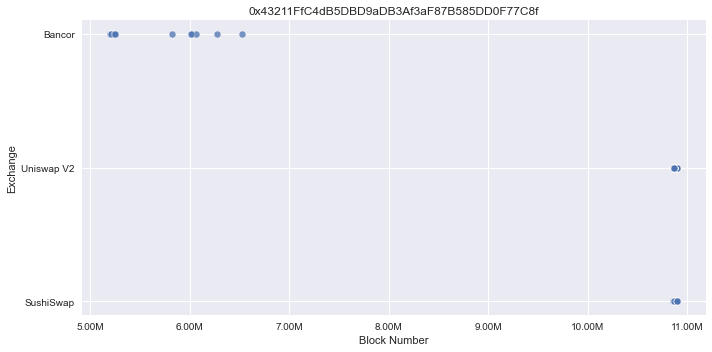

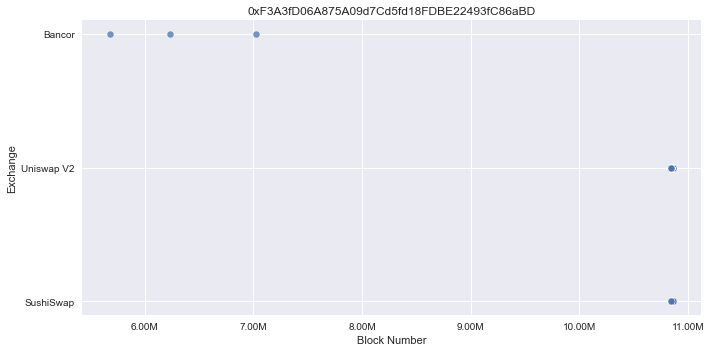

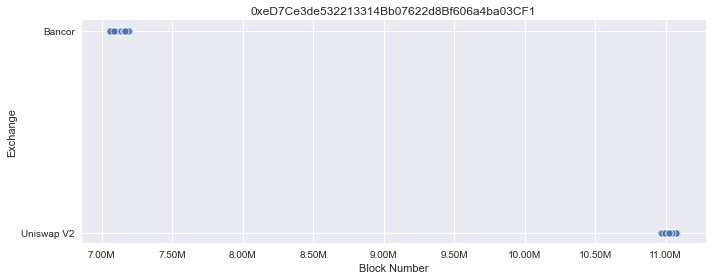

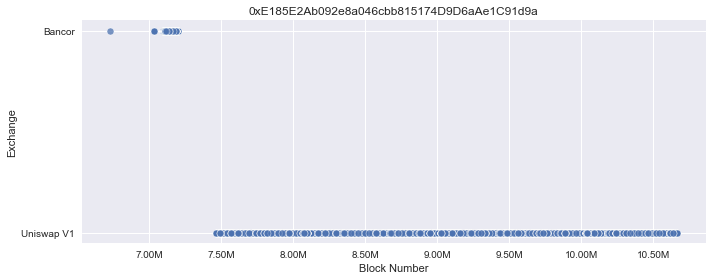

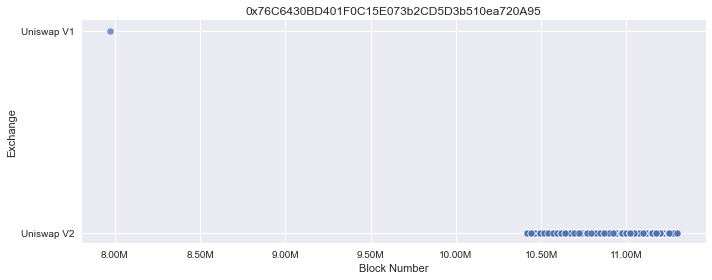

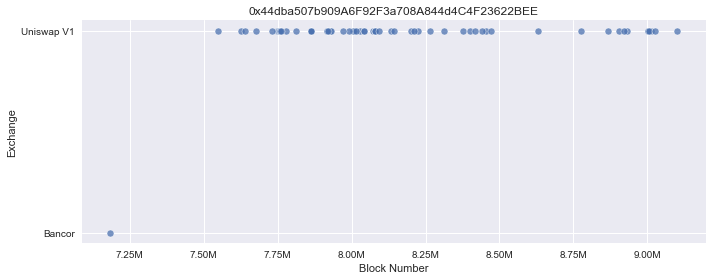

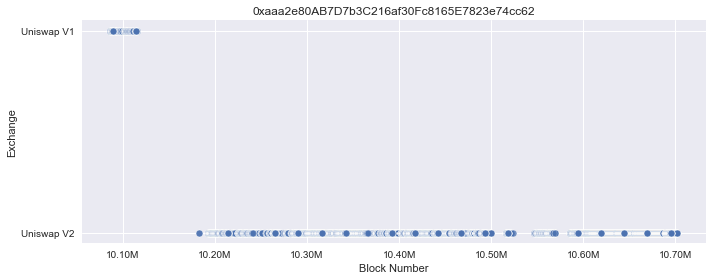

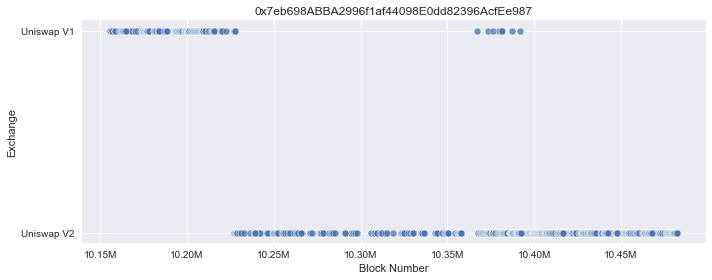

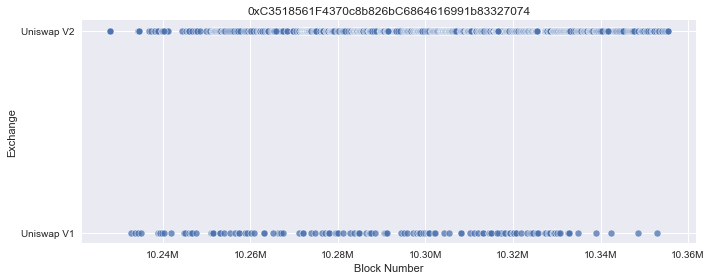

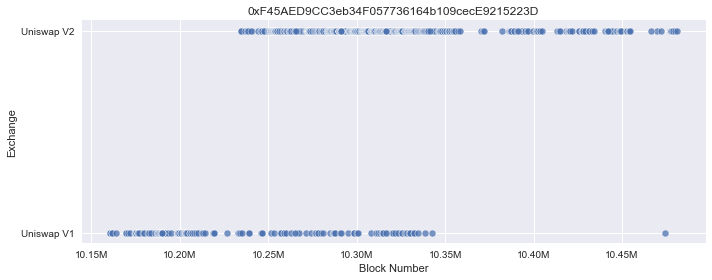

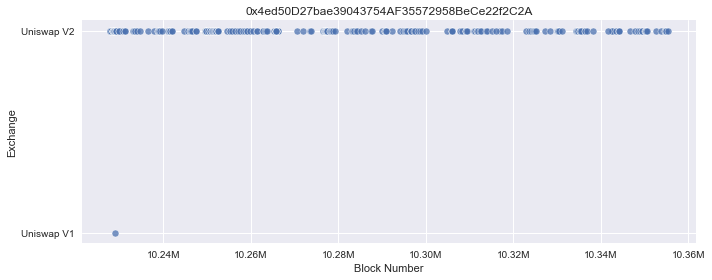

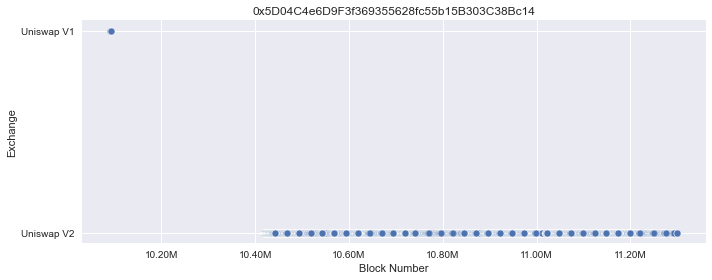

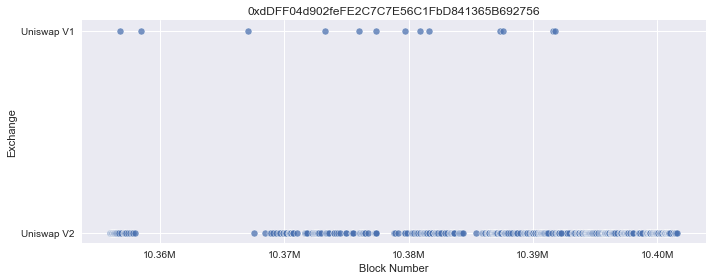

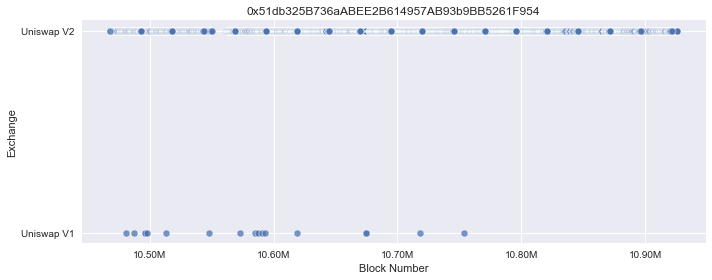

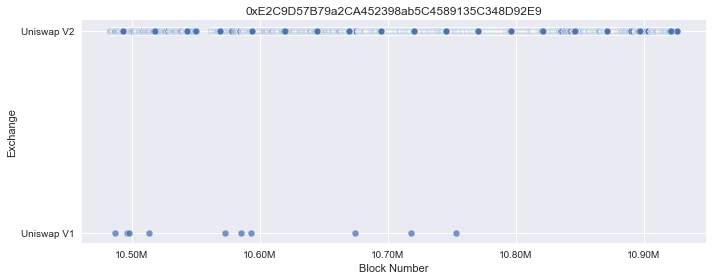

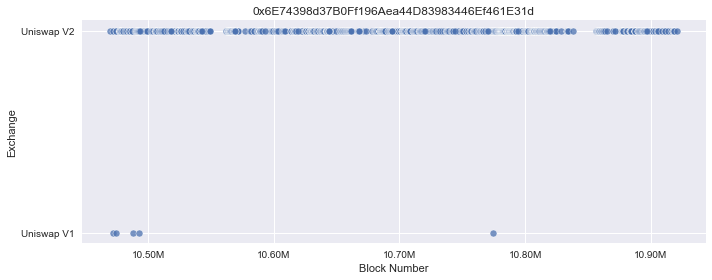

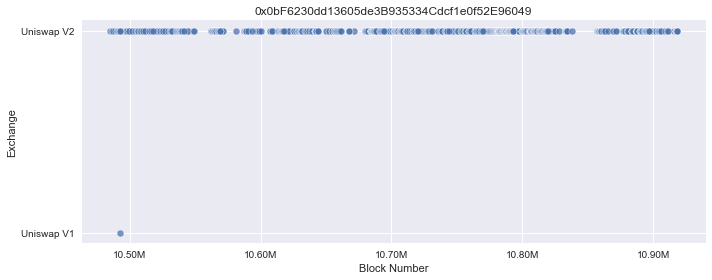

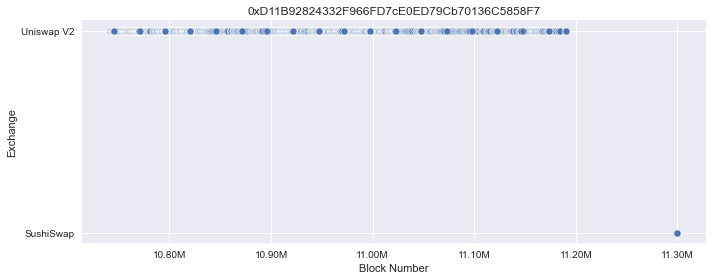

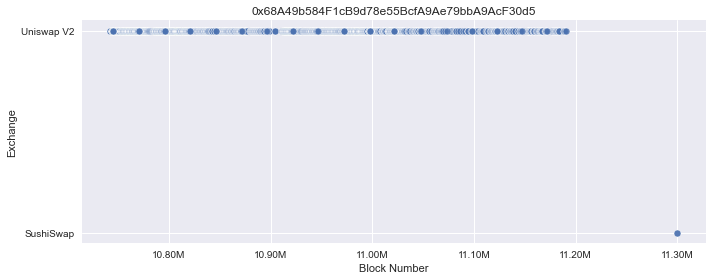

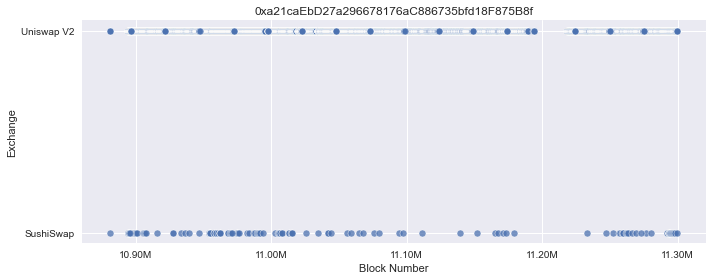

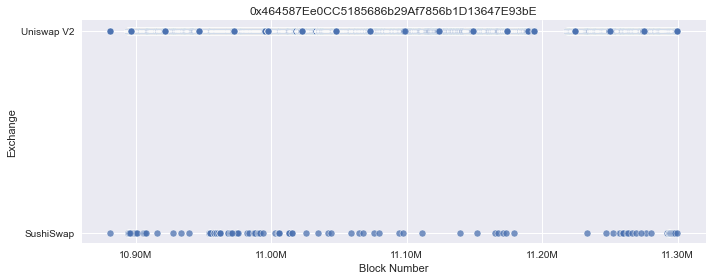

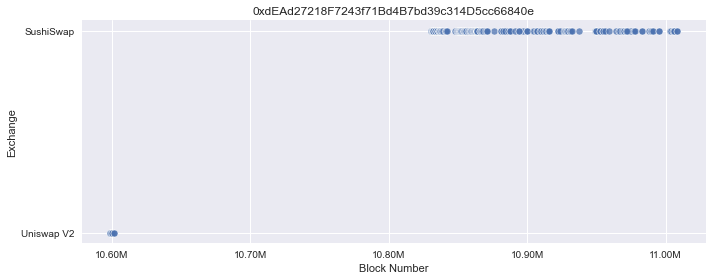

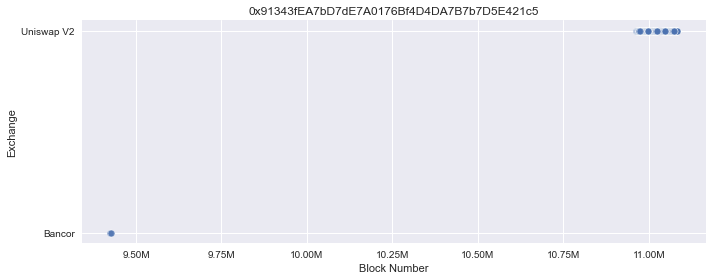

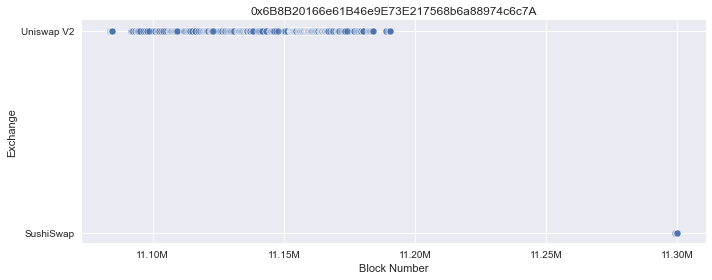

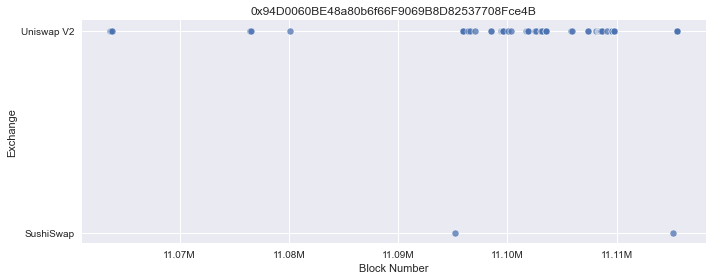

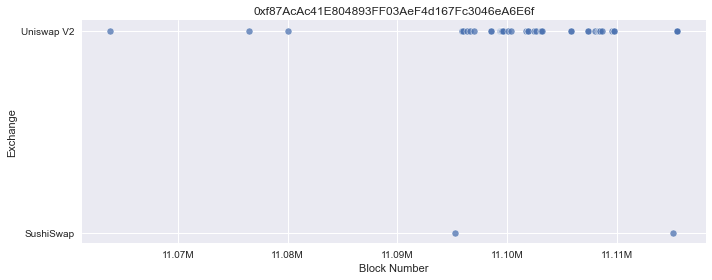

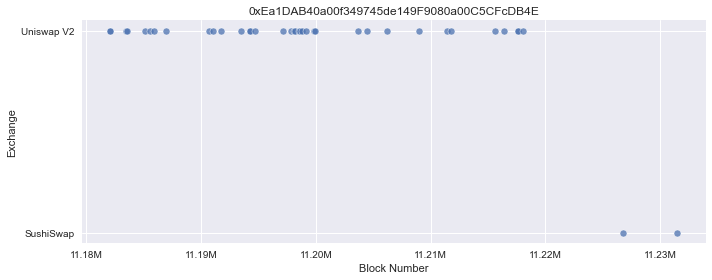

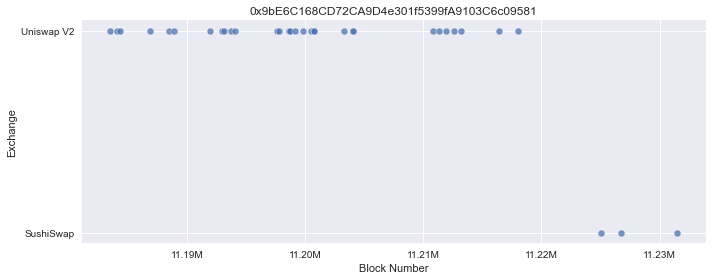

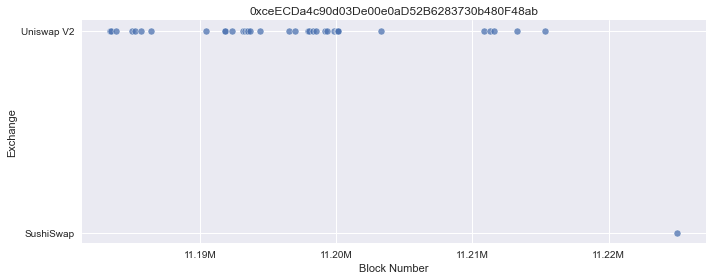

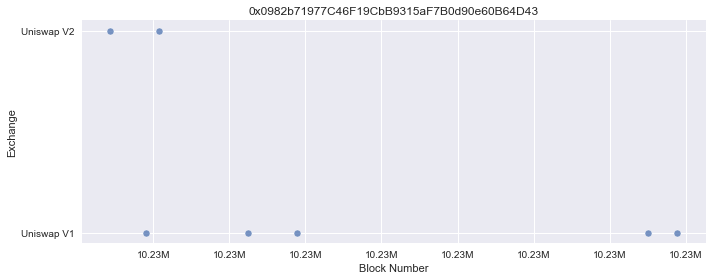

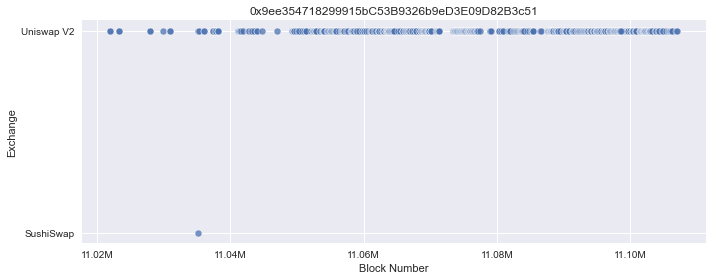

In [49]:
for attacker in df_attackers[df_attackers["Exchange Count"] > 1]["Attacker Hash"].values:
    plot_account_field_over_time(df_events, "Exchange", filters={"Account Hash": attacker})

### Distribution of number of exchanges used per bot

In [50]:
pd.DataFrame(df_bots["Exchange Count"].describe())

,Exchange Count
count,471.000000
mean,1.023355
std,0.151187
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


### Combinations of exchanges used by bots

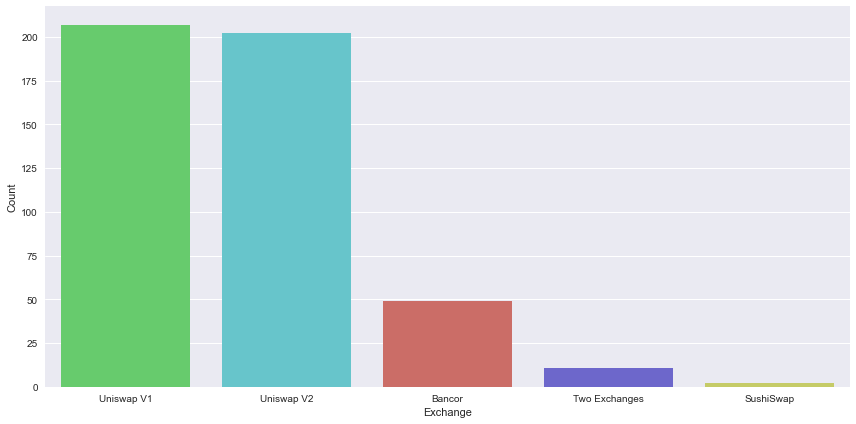

In [51]:
plot_exchange_combinations(df_bot_events, "Bot Hash")

### Exchanges used by bots over time

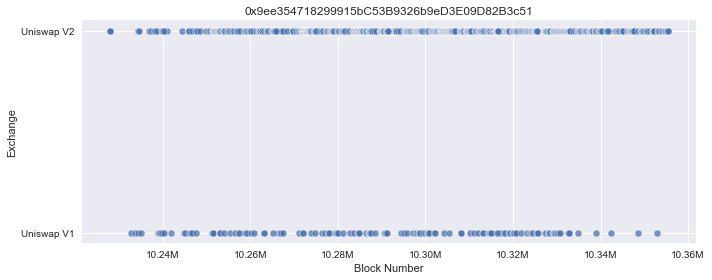

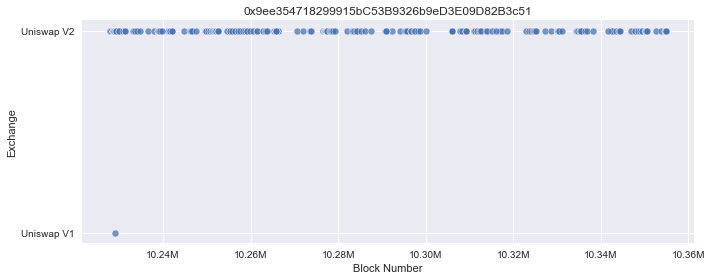

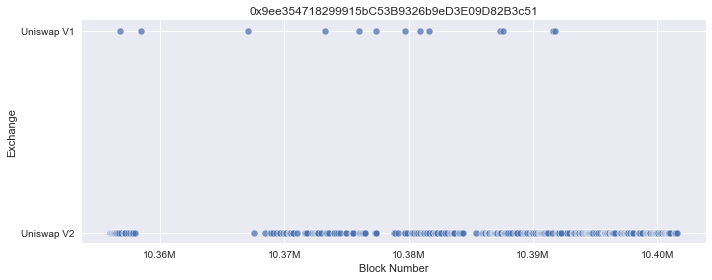

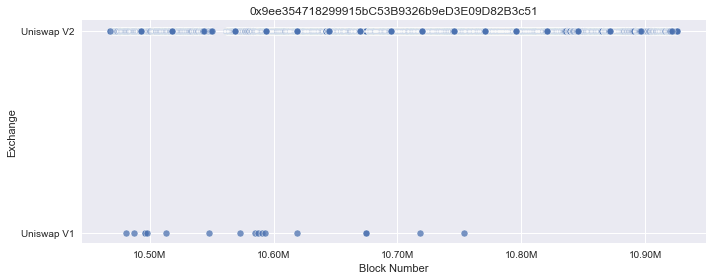

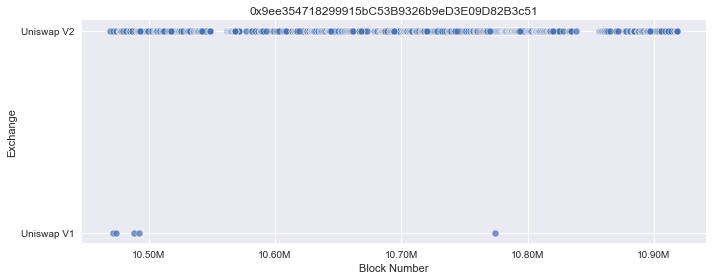

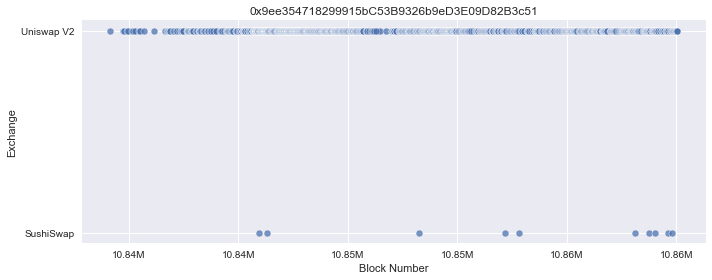

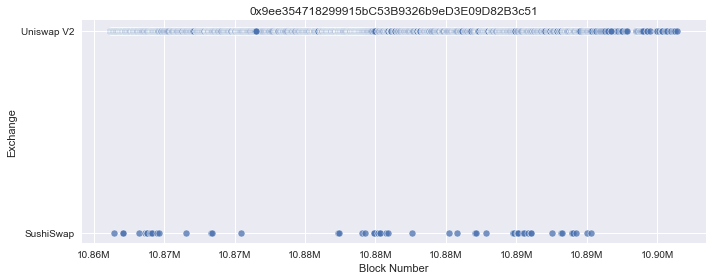

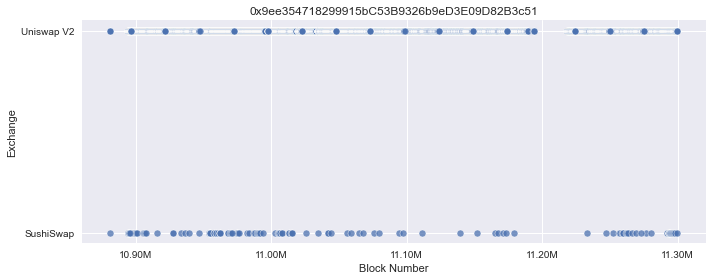

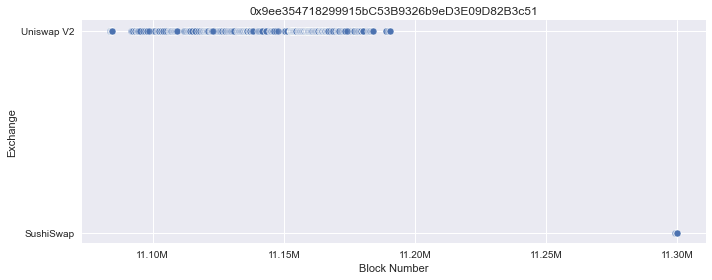

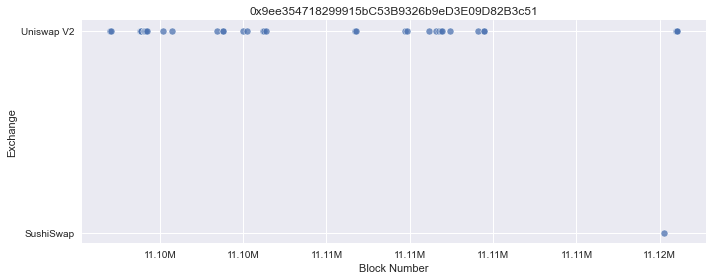

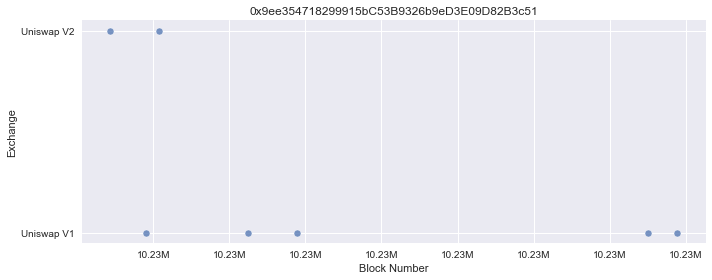

In [52]:
for bot in df_bots[df_bots["Exchange Count"] > 1]["Bot Hash"].values:
    plot_account_field_over_time(df_bot_events, "Exchange", filters={"Bot Hash": bot})

### Do attackers have more than one pair?

In [53]:
pd.DataFrame(df_attackers.Neighbors.describe())

,Neighbors
count,1504.000000
mean,1.224734
std,0.813247
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,7.000000


### Top 10 attackers with the biggest neighborhood

In [54]:
df_attackers.sort_values(by="Neighbors", ascending=False)[:10]

,Attacker Hash,First Attacks,Second Attacks,Both Attacks,Attacks,Exchange Attacks,Bot Attacks,Profit,Exchange Count,Neighbors,Bot Cluster ID
170,0x7eb698ABBA2996f1af44098E0dd82396AcfEe987,0,941,0,941,0,941,27145.865520,2,7,19
3,0x43211FfC4dB5DBD9aDB3Af3aF87B585DD0F77C8f,12,1859,12,1859,0,1859,478840.546742,3,7,1
211,0xED7cFbB8CACA87cE8EA6b4BF33288379C70b5210,2577,2579,2575,2581,0,2581,121870.861867,1,7,1
581,0x17bC12866439Db4bF991B4543416dD70c3AF8cD0,45,46,12,79,0,79,6524.990657,1,7,41
525,0xDe770fcFC5C000a825c6a64498c8EB144d138FFB,50,52,17,85,0,85,7953.936654,1,7,41
412,0xB287Cb907fE97fB4116877a924B3dfd981b5ad7D,1684,1682,1679,1687,0,1687,30219.726937,1,6,37
421,0x7117791fEa7f8da5b10C41A8B3D1C433401C74b7,1440,1441,1432,1449,0,1449,20991.262990,1,6,37
190,0x4B49a6f4ce6FA6EC7E1Ca8687c9641e0ff52548A,13,11,8,16,0,16,254.268771,1,6,1
571,0x0bC1054540787430cf624fe742bABB62220F997C,26,25,0,51,0,51,4398.855405,1,6,41
399,0xF4C3a6CA3d71fb34AF2721590D54f6b3d1ae47Bb,1350,1348,1344,1354,0,1354,22910.030163,1,6,37


### Amount of attackers per bot

In [55]:
pd.DataFrame(df_bots.Attackers.describe())

,Attackers
count,471.000000
mean,4.284501
std,40.861986
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,885.000000


### Top 10 bots with the biggest amount of attackers

In [56]:
df_bots.sort_values(by="Attackers", ascending=False)[:10].style.format({"Profit": "{:.2f}"})

,Bot Hash,Profit,Attacks,Attackers,Exchange Count,First Block,Cluster ID
167,0xec48D2C85d18992B7454474e00587765b93593eD,161810.24,3010,885,1,10594155,24
6,0x1F573D6Fb3F13d689FF844B4cE37794d79a7FF1C,-118.02,32,52,1,5525670,1
165,0x330AD9607Ff1B165eda7afF2eAAD5B56A704B873,18614.52,395,26,1,10568864,22
210,0xcDE287348FE949341d27d7f69dF049b74446573b,26212.12,604,20,1,10972442,33
373,0xaf42d382F0bf113F7334cd217fCc5f7E211f221d,5901.06,195,20,1,10952698,33
254,0x00000000DC0E59517a8114348d9130e7d3835832,38988.13,1453,20,1,11149013,33
206,0x24D17FebC2F1405f675EE45161b2A473166A952c,10458.11,300,20,1,10947235,33
221,0xAfE0e7De1FF45Bc31618B39dfE42dd9439eEBB32,164939.83,5216,20,1,10997678,33
239,0x000000a61AA8c4e48a832cc39655EF8156097aa2,30169.22,860,20,1,11123824,33
272,0xfE201551e800871f6ce0FaF141107F298440F570,26484.48,321,19,1,11224682,41


### Bot profits

In [57]:
pd.DataFrame(df_bots.Profit.describe()).style.format({"Profit": "{:.2f}"})

,Profit
count,471.00
mean,27100.21
std,164117.29
min,-2161.43
25%,4.49
50%,101.77
75%,985.48
max,1923285.04


### Top 10 most profitable bots

In [58]:
df_bots.sort_values(by="Profit", ascending=False)[:10].style.format({"Profit": "{:.2f}"})

,Bot Hash,Profit,Attacks,Attackers,Exchange Count,First Block,Cluster ID
195,0x0000000071E801062eB0544403F66176BBA42Dc0,1923285.04,11621,2,2,10896784,30
209,0x000000000000084e91743124a982076C59f10084,1850655.33,10198,10,1,10972441,32
144,0xdf1BAc82673D6B9A18D9C476Fd90bbECF00Fce5D,1802787.20,6476,3,2,10468148,19
153,0x42D0ba0223700DEa8BCA7983cc4bf0e000DEE772,1062740.28,20144,9,1,10518415,1
178,0x494Cc492c9f01699bfF1449180201dbfbD592EA5,564614.74,6857,5,1,10745425,24
193,0x743DD3139C6B70f664AB4329b2CdE646f0BaC99a,543606.33,2154,3,2,10871549,1
152,0x186e3034102d22Ca5b5482e1627d21BEEFd8C0E0,371662.34,841,3,2,10493462,19
211,0x8Be4DB5926232BC5B02b841dbeDe8161924495C4,296464.62,7770,8,1,10972445,20
204,0x000000000000740A22fA209CF6806D38f7605385,292384.48,1680,8,1,10947220,32
183,0xA0B5d75fEF7b024294411Cd92bf7E68ba5f18c99,288790.07,2738,3,1,10795905,20


### Top 10 less profitable bots

In [59]:
df_bots.sort_values(by="Profit", ascending=False)[-1:-11:-1].style.format({"Profit": "{:.2f}"})

,Bot Hash,Profit,Attacks,Attackers,Exchange Count,First Block,Cluster ID
290,0x0000015DFEf4D1cc8Eb7C5Ea84338b4072Fe58db,-2161.43,247,4,1,11249918,46
334,0x2C334D73c68bbc45dD55b13C5DeA3a8f84ea053c,-1058.96,16,2,1,10825769,21
387,0xc6cCfb911215bd76C6c14cEC0AEF8b20AEF6eB86,-865.99,7,4,1,11204682,46
457,0x6754214DE3483c87EB2DB50a8c06B7cF35027f6f,-588.84,31,2,1,11295443,46
367,0xD3661F906eA1CDC3a3689ed9ECF10544AaDa79f0,-533.80,65,1,1,11278269,70
346,0xF5ef459E90549c714Bc606dDb995F662240723d3,-307.67,19,2,1,11277356,59
454,0x53473Db3a767B1Fbe4C5b5159F88149654D2aF75,-278.79,43,2,1,11269606,46
430,0x2F6abcf728011EC4eA2c548D162A1e2363cD8f5B,-192.21,9,1,1,11262345,62
219,0x504Eb8996C656C5D27bE2E4D745FeF58aEB5D206,-187.22,10,2,1,10947518,36
215,0x876c0A82a02F41BDABd7794CEEDd013e1Cf05D8C,-180.87,39,5,1,10922473,34


### Competition

Search blocks where there is more than one attack for the same whale trading the same token.

In [60]:
df_competition = df_attacks.groupby(["Block Number", "Token", "Whale"])\
    .filter(lambda group: len(group) > 1)\
    .groupby(["Block Number", "Token", "Whale"])\
    .agg({"Block Number": "count"})\
    .rename(columns={"Block Number": "Count"})\
    .sort_values(by="Count", ascending=False)
df_competition

,,,Count
Block Number,Token,Whale,
10568277,Ampleforth,0x62e549B72a2C7D1D45435f1AC443A32A6ae24a77,4
11266821,yAxis,0x0Dd2811fF0F7C58c505957B5CaE0833ba6826DB3,4
11022923,DefiPulse Index,0xFEA0904ACc8Df0F3288b6583f60B86c36Ea52AcD,4
11028944,YELD,0x0294d5537ff34FAE228851F51C6eBFa30fBf33Ce,4
10569765,TrustSwap Token,0x5C4a3d8D3b849c4afC6748D2E5bA1730dEfE4ef1,4
...,...,...,...
10897907,HEX2T,0x96E73D0D585b271e27C4F66c74214D41Fe79AC69,2
10896703,yieldfarming.insure,0xb4aa0619a9E43E856c597c28754900f0AD6e1399,2
10896559,PickleToken,0x847Ae1887e1dc2216B59a9310b9B832303af6829,2


One example:

In [61]:
match_group(df_attacks, df_competition, 0, "Block Number")

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
140228,10568277,0xc70eE9eB352FD77CF6322F438171aAB8929372fC,0x62e549B72a2C7D1D45435f1AC443A32A6ae24a77,0xc70eE9eB352FD77CF6322F438171aAB8929372fC,45.000000,1.000000e-09,29.824267,10.238960,bot,Uniswap V2,Ampleforth,0x8fF4Ff42F07cBa81748F7C6969F2750da2c6F7dB,22.0
140238,10568277,0x6E74398d37B0Ff196Aea44D83983446Ef461E31d,0x62e549B72a2C7D1D45435f1AC443A32A6ae24a77,0x6E74398d37B0Ff196Aea44D83983446Ef461E31d,70.548001,1.000000e-09,243.048143,12.798495,bot,Uniswap V2,Ampleforth,0x186e3034102d22Ca5b5482e1627d21BEEFd8C0E0,19.0
140246,10568277,0x5C2Bc88f19674FBF71BCeDe54f88E6b05ede40D7,0x62e549B72a2C7D1D45435f1AC443A32A6ae24a77,0x69A895686ab085D703071D6c6ffb49a40FF3efB4,86.379195,1.000000e-09,84.289786,14.845382,bot,Uniswap V2,Ampleforth,0x284900d5aB66356FBF936A0469aB0E138F965114,21.0
140254,10568277,0xb0538eFb71D17bf361c143CaaEEB35a0e14E060c,0x62e549B72a2C7D1D45435f1AC443A32A6ae24a77,0xb0538eFb71D17bf361c143CaaEEB35a0e14E060c,151.593175,1.000000e-09,24.801153,14.820788,bot,Uniswap V2,Ampleforth,0x330AD9607Ff1B165eda7afF2eAAD5B56A704B873,22.0


### Chain attack

Search blocks where there is more than one attack for the same token, where an attacker is also a whale.

In [62]:
def attackers_are_victims_in_block(group):
    if len(group) <= 1:
        return False
    
    whales = set(group["Whale"].unique())
    
    if len(whales) == 1:
        return False
    
    first_attackers = set(group["First Attacker"].unique())
    second_attackers = set(group["Second Attacker"].unique())
    attackers = first_attackers.union(second_attackers)
    return len(attackers.intersection(whales)) > 0

df_chain_attacks = df_attacks.groupby(["Block Number", "Token"])\
    .filter(attackers_are_victims_in_block)\
    .groupby(["Block Number", "Token"])\
    .agg({"Block Number": "count"})\
    .rename(columns={"Block Number": "Count"})\
    .sort_values(by="Count", ascending=False)
df_chain_attacks

,,Count
Block Number,Token,
11190219,Lightning Pool,2
11269029,SMARTCREDIT Token,2


There are two cases.

The first case where 0x5e334032Fca55814dDb77379D8f99c6eb30dEa6a	 is both an attacker and a whale:

In [63]:
match_group(df_attacks, df_chain_attacks, 0, "Block Number")

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
148798,11190219,0x5e334032Fca55814dDb77379D8f99c6eb30dEa6a,0xe46BB9aEE8ba9C837E5F0bA5748D3BDEa2293a20,0x5e334032Fca55814dDb77379D8f99c6eb30dEa6a,1.000000e+01,1.000000e-09,103.015292,3.278273,bot,Uniswap V2,Lightning Pool,0x2d64e332bB6b61551Bb5Dd9448eFd0Fa74FD6Aeb,39.0
148805,11190219,0x001182890A094820eb9d4401693Ba0B9554F0f66,0x5e334032Fca55814dDb77379D8f99c6eb30dEa6a,0x001182890A094820eb9d4401693Ba0B9554F0f66,1.000000e-09,1.000000e+01,368.061151,3.719535,bot,Uniswap V2,Lightning Pool,0xE860DA4d95e0eb555eCc22Ef06B780754DAAa8b8,48.0


The second case where 0xB5AD1C4305828636F32B04E5B5Db558de447eAff is both an attacker and a whale:

In [64]:
match_group(df_attacks, df_chain_attacks, 1, "Block Number")

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
168313,11269029,0xB5AD1C4305828636F32B04E5B5Db558de447eAff,0xFd2fF6Ac2194A8a573d341C3Ba639551475080ea,0xB5AD1C4305828636F32B04E5B5Db558de447eAff,8.400000,2.000000e-07,-1.498311,2.910567,bot,Uniswap V2,SMARTCREDIT Token,0x5014223597F807D542E85431C42b926E2CDa86a6,86.0
168318,11269029,0x7777771F3a0DFBfFe0E995cCe5fA175b1d7AeDee,0xC42C13448876232CA8B90e37e23e411141BEC41D,0x7777771F3a0DFBfFe0E995cCe5fA175b1d7AeDee,113.594521,1.000000e-09,3.337170,6.387647,bot,Uniswap V2,yfi.name,0x16c00b7276bEf7D97A72e61526819A9165C63d2c,47.0
168324,11269029,0x4F69c5B694D5A14a0a595703175c478Ec6B2a2Fe,0xB5AD1C4305828636F32B04E5B5Db558de447eAff,0x74b892425a206eb23905a5F5C322e4386460312d,219.572772,7.672046e+01,-7.498838,9.833344,bot,Uniswap V2,SMARTCREDIT Token,0x00bF034ceC51975FaeCe51b285724301436B21C4,20.0


### Bot cluster conflicts

Search blocks where there is more than one attack for the same whale trading the same token and the attackers belong to the same bot cluster.

Filter the attacks with undefined bot cluster in case the file is not properly updated.

In [65]:
df_bot_bluster_conflicts = df_attacks.dropna().groupby(["Block Number", "Token", "Whale", "Bot Cluster ID"])\
    .filter(lambda group: len(group) > 1)\
    .groupby(["Block Number", "Token", "Whale", "Bot Cluster ID"])\
    .agg({"Block Number": "count"})\
    .rename(columns={"Block Number": "Count"})\
    .sort_values(by="Count", ascending=False)
df_bot_bluster_conflicts

,,,,Count
Block Number,Token,Whale,Bot Cluster ID,
6609802,Bancor Network Token,0x0DC411b17d337Af85D83eA5A3577D09132Aae866,1.0,2
11151342,BUILD Finance,0x6f7ABAAA7f16B0A1C1FA1C89fDF286fC805203bC,32.0,2
11050168,EarnDefiCoin,0xB9cD2DAaC4E0Ebcf2Da51705a0f02EEe13072C3c,32.0,2
11054899,RMPL,0xF1e8a3999E6C3bB9a518C3Ef7F9bF621586a76Ff,32.0,2
11062610,Hermez Network Token,0x3E11d657331c286624826ac797a974777be0e47F,32.0,2
...,...,...,...,...
7164175,X8XToken,0x81083aa7e215bD99547abC890D5B47f88bf11F99,1.0,2
7164281,Amon,0x305B2620f145f9da5eE724A93E81D1624320C0aC,1.0,2
7165582,Transcodium,0xd35612B2613DA43b4E9ADaB1E9Aa985D1490d5a7,1.0,2


One example where two attackers from bot cluster 32 are attacking 0x6f7ABAAA7f16B0A1C1FA1C89fDF286fC805203bC:

In [66]:
match_group(df_attacks, df_bot_bluster_conflicts, 1, "Block Number")

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
40859,11151342,0xe73c1E4d7992a4A4f19f31531AE7b5DC352b74B0,0x6f7ABAAA7f16B0A1C1FA1C89fDF286fC805203bC,0x725277600A1b1416EAB510AabEdBf6911e0bbD84,6.398340e-04,0.000000e+00,543.040782,11.626155,bot,Uniswap V2,BUILD Finance,0x855A5b16782304D3382dd764ef69a10EfbEB9A77,32.0
40863,11151342,0x81417BE380C325E17AFdA27890226E568f039c53,0x45F21B16088C13A58f930D0cC778470Bf2c357b9,0x81417BE380C325E17AFdA27890226E568f039c53,1.000000e-08,0.000000e+00,380.125376,18.666521,bot,Uniswap V2,SURF.Finance,0x80eB692DBe46EA68FA9Bb1C7bFD2201a101873fa,41.0
40870,11151342,0xdD07249e403979Bd79848c27aa5454C7E66BdEe7,0x6f7ABAAA7f16B0A1C1FA1C89fDF286fC805203bC,0xdB9c8428e68a1E6B2244C92127D2dcD708F893f4,2.374533e+03,1.000000e-08,246.551419,67.546759,bot,Uniswap V2,BUILD Finance,0x000000000000084e91743124a982076C59f10084,32.0


How many times this happens for each bot cluster?

In [67]:
df_bot_bluster_conflicts.reset_index()["Bot Cluster ID"].value_counts()

1.0     128
32.0    112
13.0      9
19.0      5
5.0       4
20.0      4
22.0      3
24.0      3
9.0       1
21.0      1
Name: Bot Cluster ID, dtype: int64

### Interface counts

In [68]:
df_attacks.Interface.value_counts()

bot         194018
exchange      2673
Name: Interface, dtype: int64

In [69]:
df_attacks.Interface.value_counts(normalize=True)

bot         0.98641
exchange    0.01359
Name: Interface, dtype: float64

### Attack variable correlations

In [70]:
df_attacks[[
        "Cost",
        "Profit",
        "First-Whale Gas Price Delta",
        "Whale-Second Gas Price Delta",
    ]].corr().style.format("{:.2f}").background_gradient(cmap='coolwarm')

,Cost,Profit,First-Whale Gas Price Delta,Whale-Second Gas Price Delta
Cost,1.00,0.11,0.95,0.09
Profit,0.11,1.00,0.08,0.01
First-Whale Gas Price Delta,0.95,0.08,1.00,0.02
Whale-Second Gas Price Delta,0.09,0.01,0.02,1.00


### Exchange counts

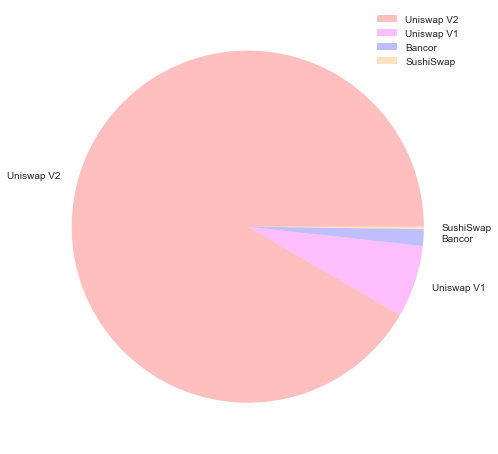

In [71]:
exchange_colors = {
    "Bancor": (0, 0, 1, 0.25), #"#0000FF", #"blue",
    "Uniswap V1": (1, 0, 1, 0.25), #"#FF00FF", #"fuchsia",
    "Uniswap V2": (1, 0, 0, 0.25), #"#FF0000", #"red",
    "SushiSwap": (1, 140 / 255, 0, 0.25), #"#FF8C00" #"darkorange",
}
exchange_counts = df_attacks.Exchange.value_counts().to_dict()
plt.figure(figsize=(7, 7))
plt.pie(exchange_counts.values(), labels=exchange_counts.keys(), colors=[
    exchange_colors[exchange] for exchange in exchange_counts.keys()
])

plt.tight_layout()
plt.legend()
plt.show()